In [5]:
import keras
from keras import layers
from keras import ops

import os
import numpy as np
from glob import glob
import cv2
from scipy.io import loadmat
import matplotlib.pyplot as plt

# For data preprocessing
from tensorflow import image as tf_image
from tensorflow import data as tf_data
from tensorflow import io as tf_io

In [4]:
# for i in range(300):
#     image = cv2.imread(f"C:/Users/iraor/dataset/lbl_val/image{i}.png")
#     for j in range(image.shape[0]):
#         for k in range(image.shape[0]):
#             if list(image[j,k]) == [1, 1, 1]: image[j,k] = [99, 6, 212]
#             elif list(image[j,k]) == [2, 2, 2]: image[j,k] = [127, 170, 85]
#             elif list(image[j,k]) == [3, 3, 3]: image[j,k] = [255, 133, 121]
#     cv2.imwrite(f"C:/Users/iraor/dataset/lbl_val/image{i}.png", image)

In [5]:


# for i in range(1000):
#     os.rename(f"C:/Users/iraor/apples_dataset/apple3/original/image{i}.png", f"C:/Users/iraor/apples_dataset/apple3/original/image{i+2000}.png")
# def grey_img(image):
#     img_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     return img_grey


# image = cv2.imread("C:/Users/iraor/dataset/lbl/image0.png")
# img_grey = grey_img(image)

# cv2.imshow('img_grey', img_grey)


# cv2.waitKey(0)

# cv2.destroyAllWindows()


# Creating Dataset

In [6]:
CLASSES = [
    'фон',
    'яблоко',
]

colormap = [
    [0, 0, 0],
    [212, 6, 99]
]


IMAGE_SIZE = 512
BATCH_SIZE = 4
NUM_CLASSES = 2
DATA_DIR = "./apples_dataset2"
NUM_TRAIN_IMAGES = 3000
NUM_VAL_IMAGES = 333

train_images = sorted(glob(os.path.join(DATA_DIR, "img_train/*")))[:NUM_TRAIN_IMAGES]
train_masks = sorted(glob(os.path.join(DATA_DIR, "lbl_train/*")))[:NUM_TRAIN_IMAGES]
val_images = sorted(glob(os.path.join(DATA_DIR, "img_val/*")))[:NUM_VAL_IMAGES]
val_masks = sorted(glob(os.path.join(DATA_DIR, "lbl_val/*")))[:NUM_VAL_IMAGES]


def read_image(image_path, mask=False):
    image = tf_io.read_file(image_path)
    if mask:
        image = tf_image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf_image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    else:
        image = tf_image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf_image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    return image


def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask


def data_generator(image_list, mask_list):
    dataset = tf_data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf_data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)

print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

Train Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(4, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 512, 512, 1), dtype=tf.float32, name=None))>
Val Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(4, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 512, 512, 1), dtype=tf.float32, name=None))>


# Building the DeepLabV3+ model

In [7]:

def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return ops.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]),
        interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output


In [8]:

def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    preprocessed = keras.applications.resnet50.preprocess_input(model_input)
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=preprocessed
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)


model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃     Param # ┃ Connected to                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 512, 512, 3)       │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ get_item (GetItem)            │ (None, 512, 512)          │           0 │ input_layer[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ get_item_1 (GetItem)          │ (None, 512, 512)          │           0 │ input_layer[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ get_item_2 (GetItem)          │ (None, 512, 512)          │           0 │ input_layer[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ stack (Stack)                 │ (None, 512, 512, 3)       │           0 │ get_item[0][0],                │
│                               │                           │             │ get_item_1[0][0],              │
│                               │                           │             │ get_item_2[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ add (Add)                     │ (None, 512, 512, 3)       │           0 │ stack[0][0]                    │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 518, 518, 3)       │           0 │ add[0][0]                      │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 256, 256, 64)      │       9,472 │ conv1_pad[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 256, 256, 64)      │         256 │ conv1_conv[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 256, 256, 64)      │           0 │ conv1_bn[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 258, 258, 64)      │           0 │ conv1_relu[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 128, 128, 64)      │           0 │ pool1_pad[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 128, 128, 64)      │       4,160 │ pool1_pool[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 128, 128, 64)      │         256 │ conv2_block1_1_conv[0][0]      │
│ (BatchNormalization)          │                           │             │                                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 128, 128, 64)      │           0 │ conv2_block1_1_bn[0][0]        │
│ (Activation)                  │                           │             │                                │
├───────────────────────────────┼───────────────────────────┼─────────────┼─

 Total params: 11,852,610 (45.21 MB)

 Trainable params: 11,819,874 (45.09 MB)

 Non-trainable params: 32,736 (127.88 KB)

# Training

Epoch 1/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 9029s 12s/step - accuracy: 0.9696 - loss: 0.0772 - val_accuracy: 0.9842 - val_loss: 0.0422
Epoch 2/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 8987s 12s/step - accuracy: 0.9867 - loss: 0.0310 - val_accuracy: 0.9909 - val_loss: 0.0244
Epoch 3/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 8989s 12s/step - accuracy: 0.9893 - loss: 0.0254 - val_accuracy: 0.9872 - val_loss: 0.0353
Epoch 4/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 9001s 12s/step - accuracy: 0.9908 - loss: 0.0218 - val_accuracy: 0.9884 - val_loss: 0.0240
Epoch 5/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 9011s 12s/step - accuracy: 0.9909 - loss: 0.0210 - val_accuracy: 0.9842 - val_loss: 0.0346


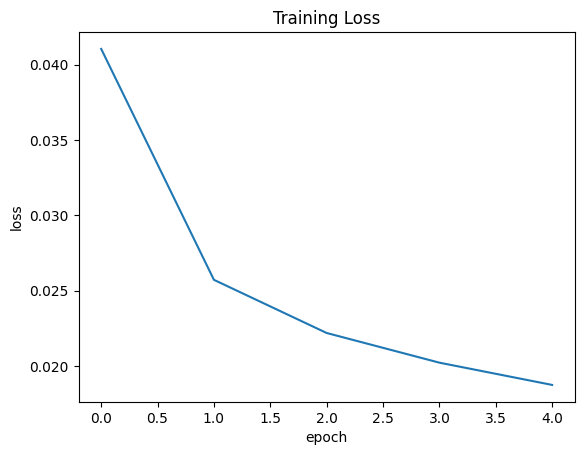

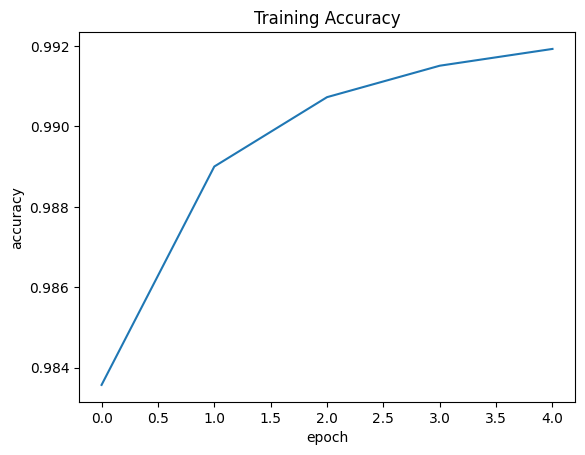

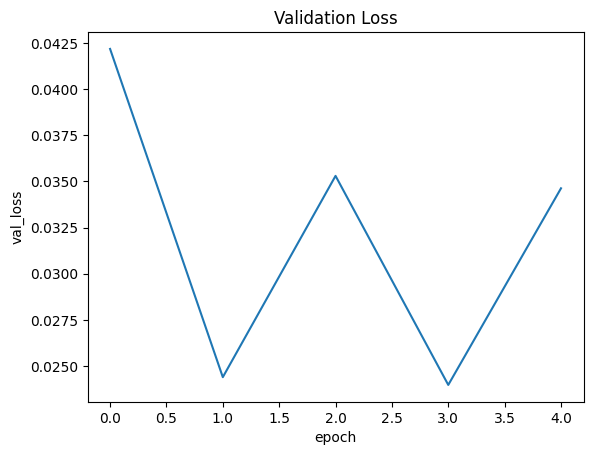

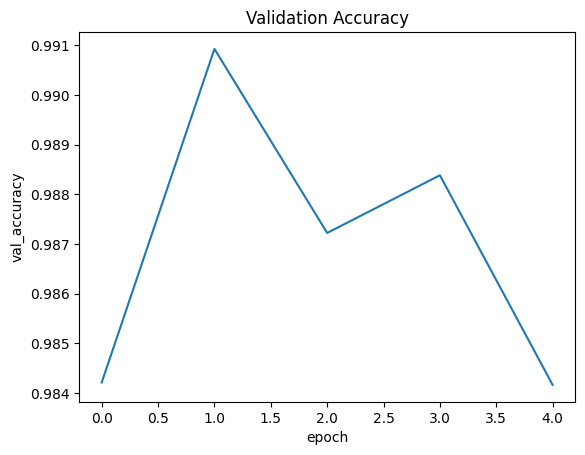

In [9]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=loss,
    metrics=["accuracy"],
)

history = model.fit(train_dataset, validation_data=val_dataset, epochs=5)

plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()

## Inference using Colormap Overlay



In [20]:
def infer(model, image_tensor):
    predictions = model.predict(np.expand_dims((image_tensor), axis=0))
    predictions = np.squeeze(predictions)
    predictions = np.argmax(predictions, axis=2)
    return predictions


def decode_segmentation_masks(mask, colormap, n_classes):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)

    # print(mask[250])

    
    for l in range(0, n_classes):
        idx = mask == l
        r[idx] = colormap[l][0]
        g[idx] = colormap[l][1]
        b[idx] = colormap[l][2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb


def get_overlay(image, colored_mask):
    image = keras.utils.array_to_img(image)
    image = np.array(image).astype(np.uint8)
    overlay = cv2.addWeighted(image, 0.35, colored_mask, 0.65, 0)
    return overlay


def plot_samples_matplotlib(display_list, figsize=(5, 3)):
    _, axes = plt.subplots(nrows=1, ncols=len(display_list), figsize=figsize)
    for i in range(len(display_list)):
        if display_list[i].shape[-1] == 3:
            axes[i].imshow(keras.utils.array_to_img(display_list[i]))
        else:
            axes[i].imshow(display_list[i])
    plt.show()


def plot_predictions(images_list, colormap, model, mask_pred=False):
    for image_file in images_list:
        image_tensor = read_image(image_file)
        prediction_mask = infer(image_tensor=image_tensor, model=model)
        prediction_colormap = decode_segmentation_masks(prediction_mask, colormap, len(CLASSES))

        if mask_pred:
            name = image_file.split("\\")[2]
            path = f"C:/Users/iraor/apples_dataset2/mask_predict/{name}"
            pred_map = cv2.cvtColor(prediction_colormap, cv2.COLOR_BGR2RGB)
            cv2.imwrite(path, pred_map)
            
        overlay = get_overlay(image_tensor, prediction_colormap)
        plot_samples_matplotlib(
            [image_tensor, overlay, prediction_colormap], figsize=(18, 14)
        )



### Inference on Train Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


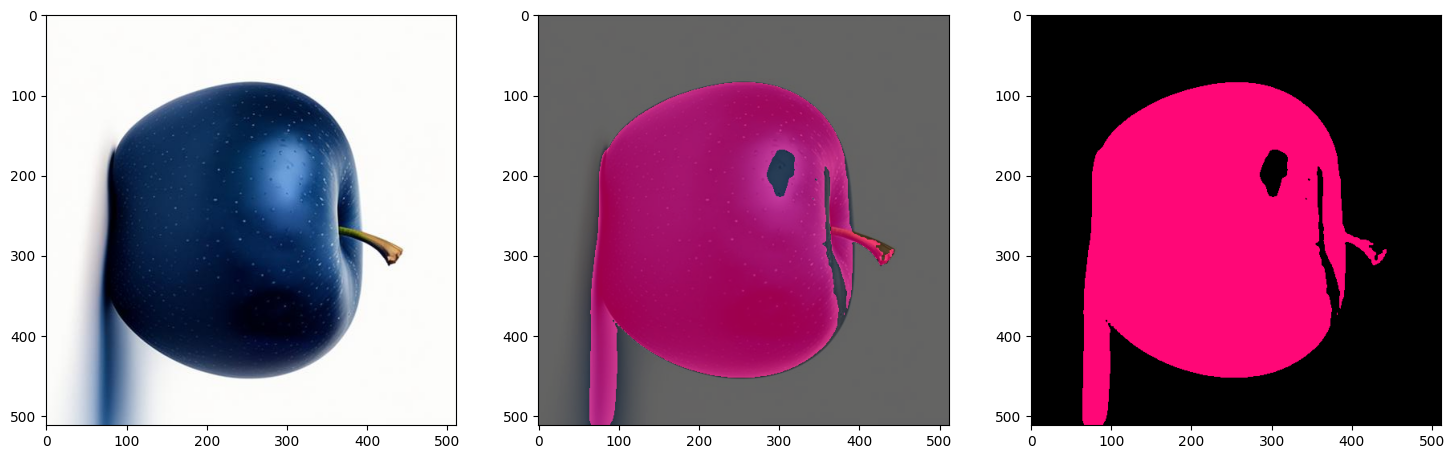

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step


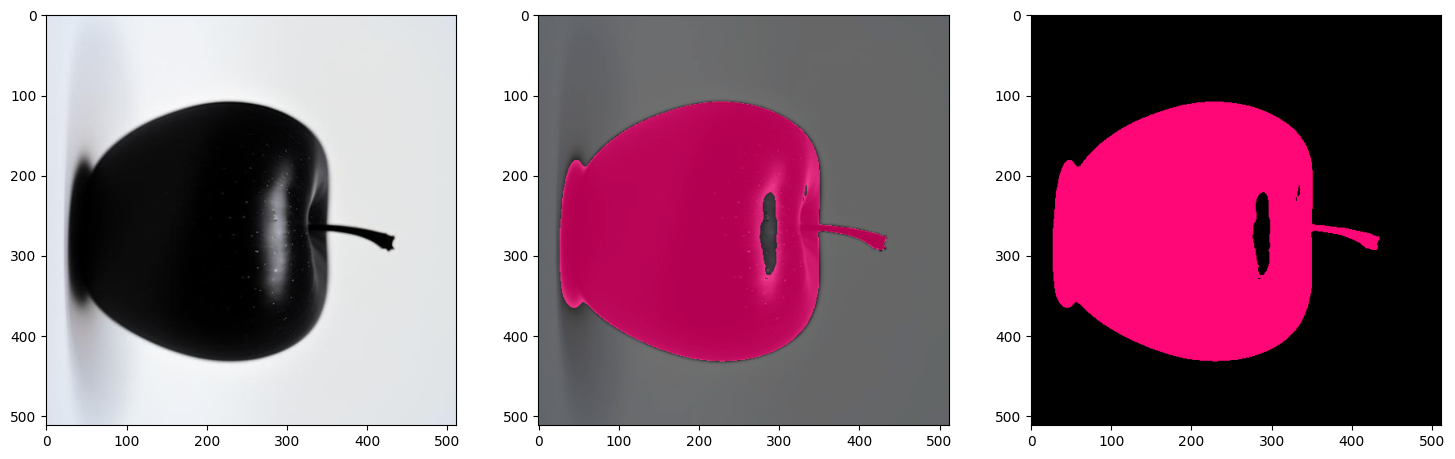

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step


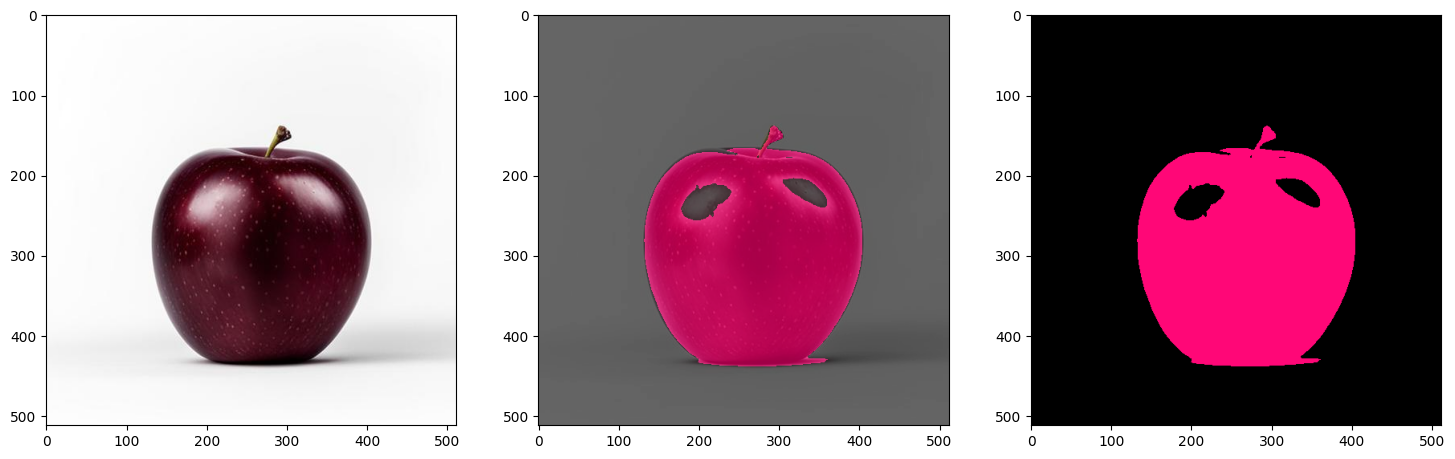

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step


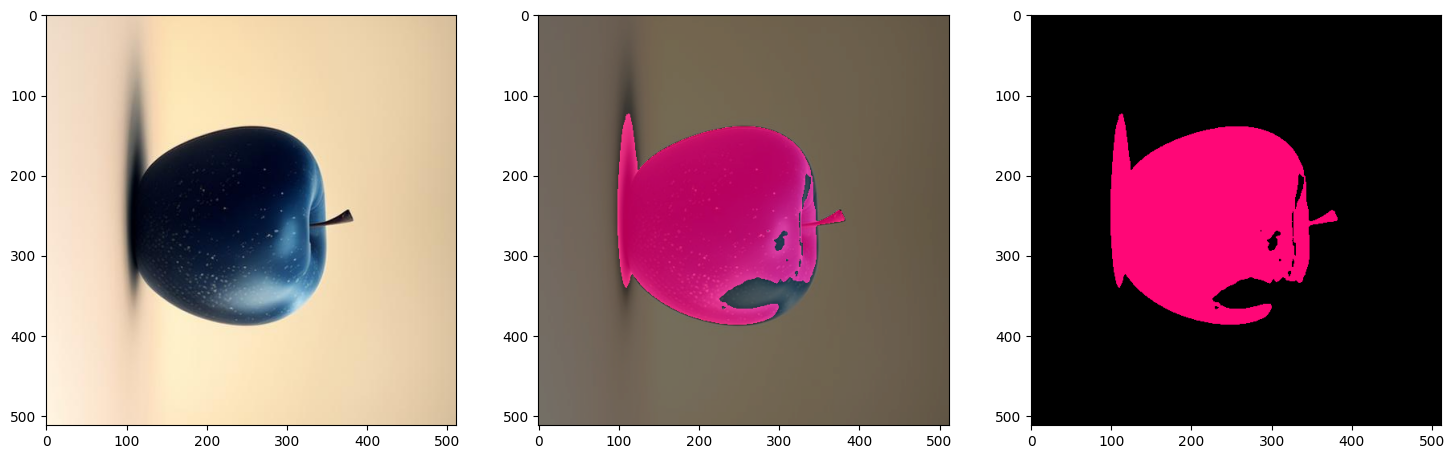

In [25]:
plot_predictions(train_images[:4], colormap, model=model)

### Inference on Validation Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step


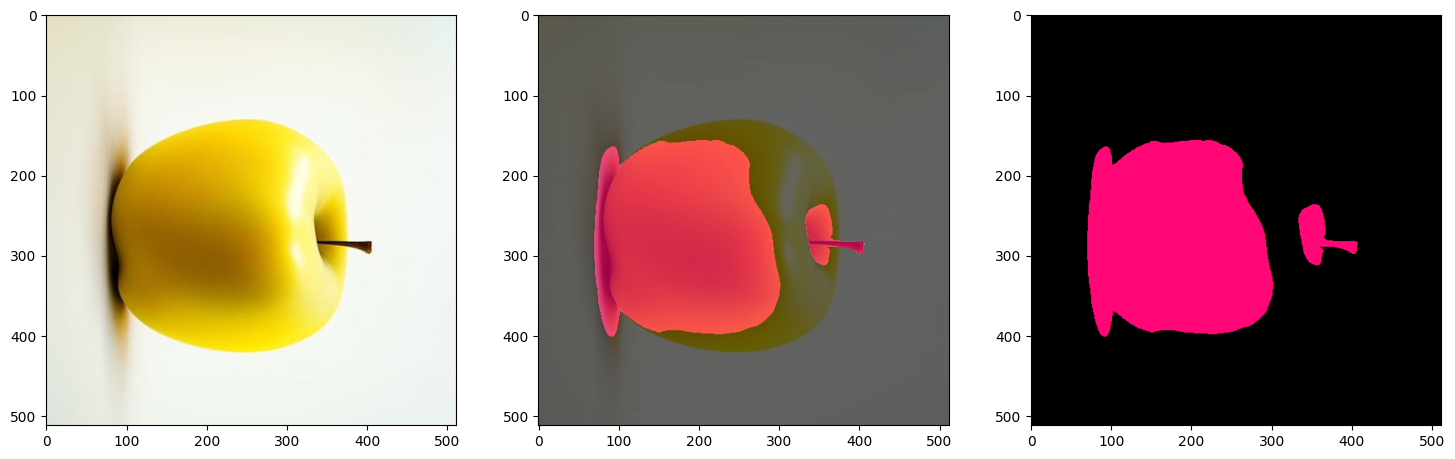

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


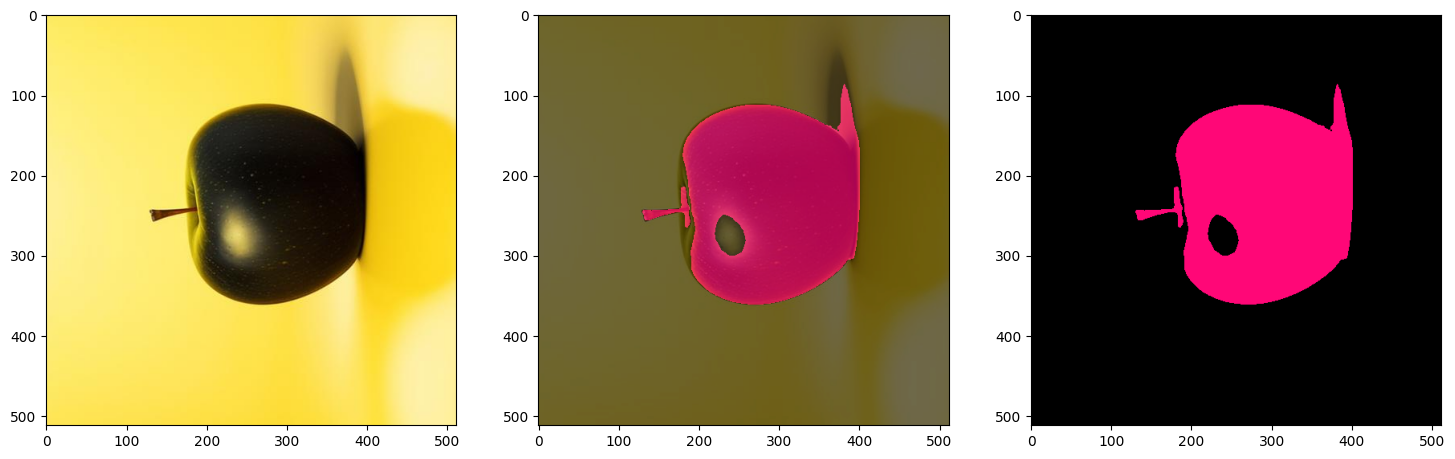

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step


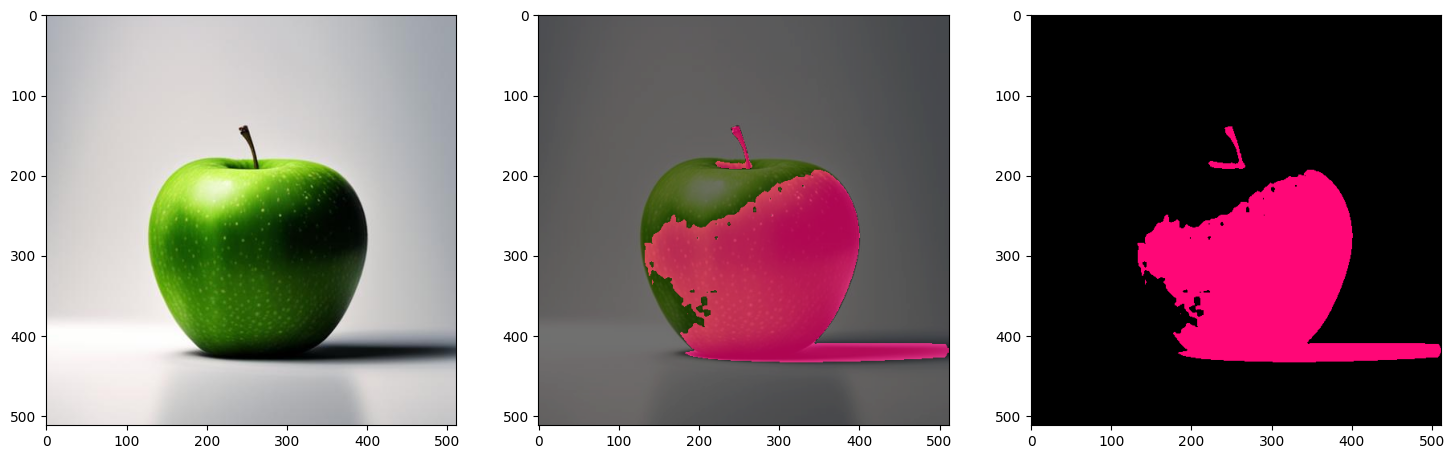

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step


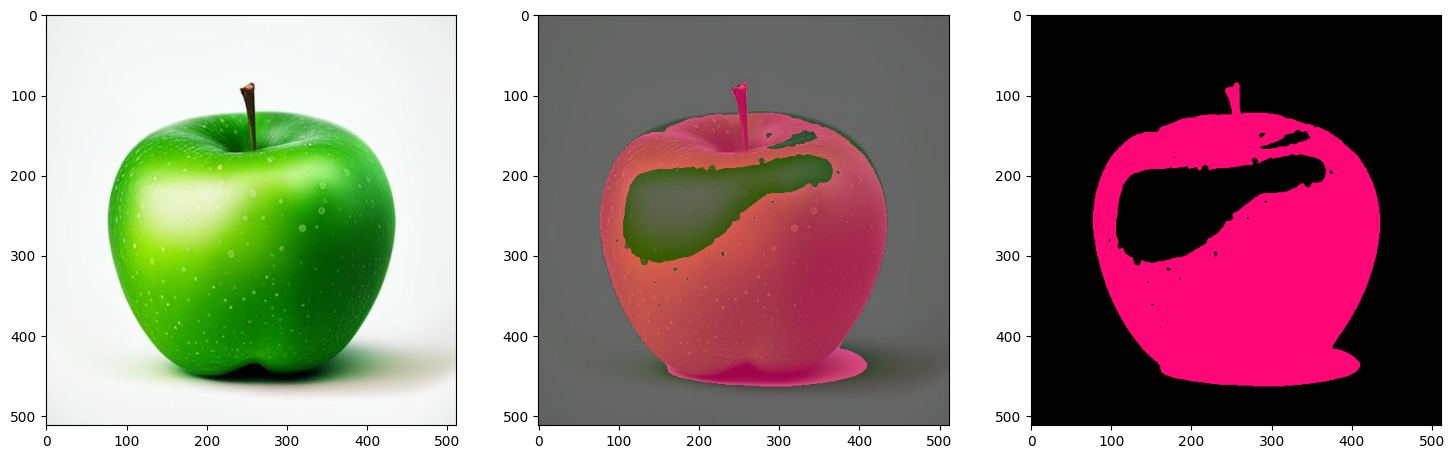

In [26]:
plot_predictions(val_images[290:294], colormap, model=model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step


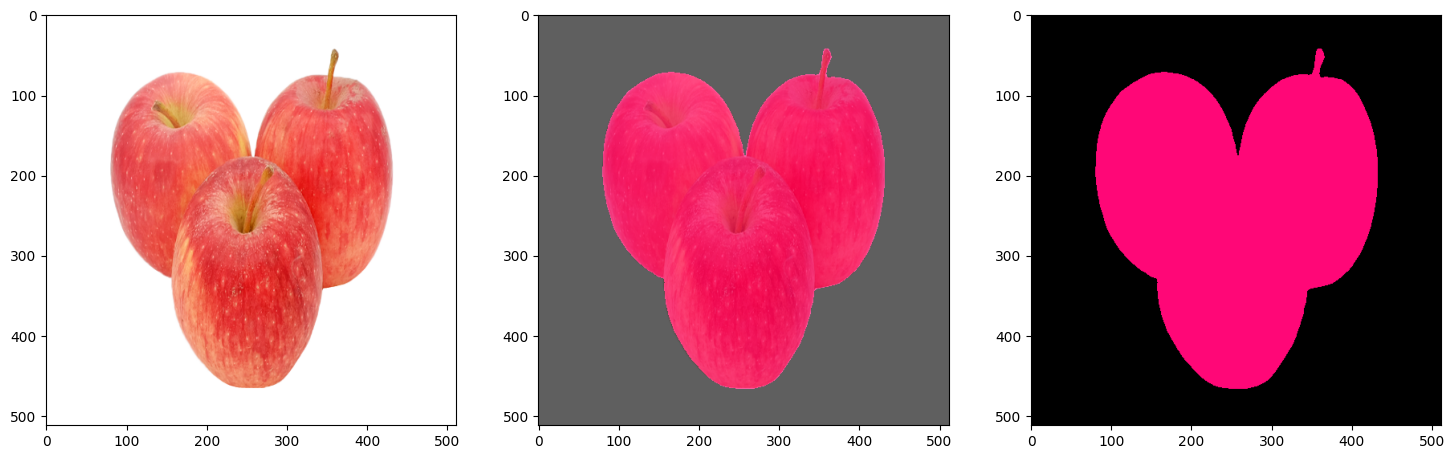

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


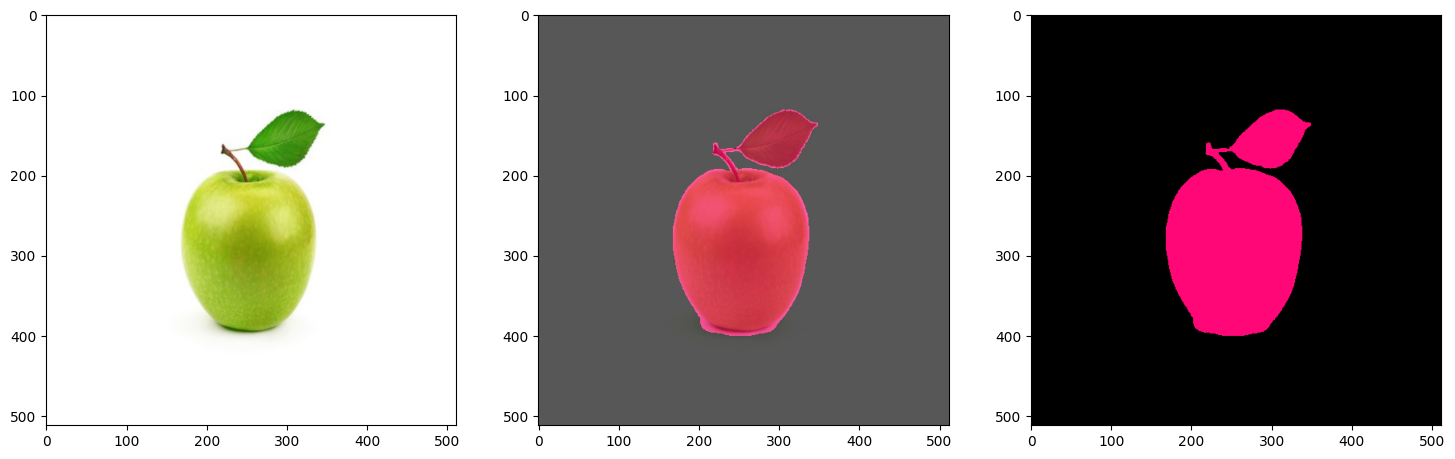

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step


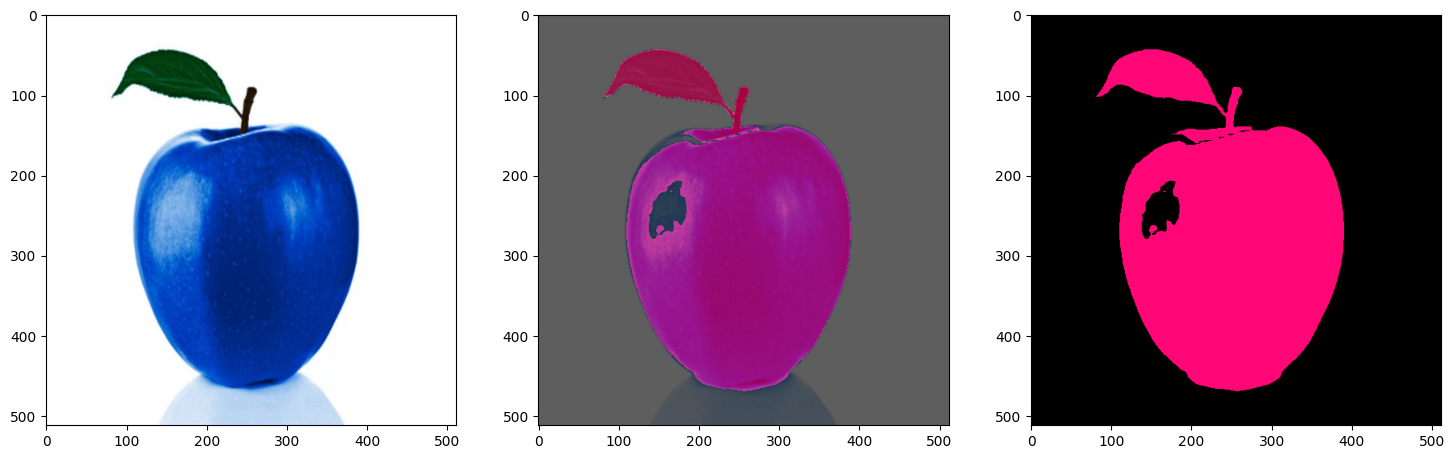

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


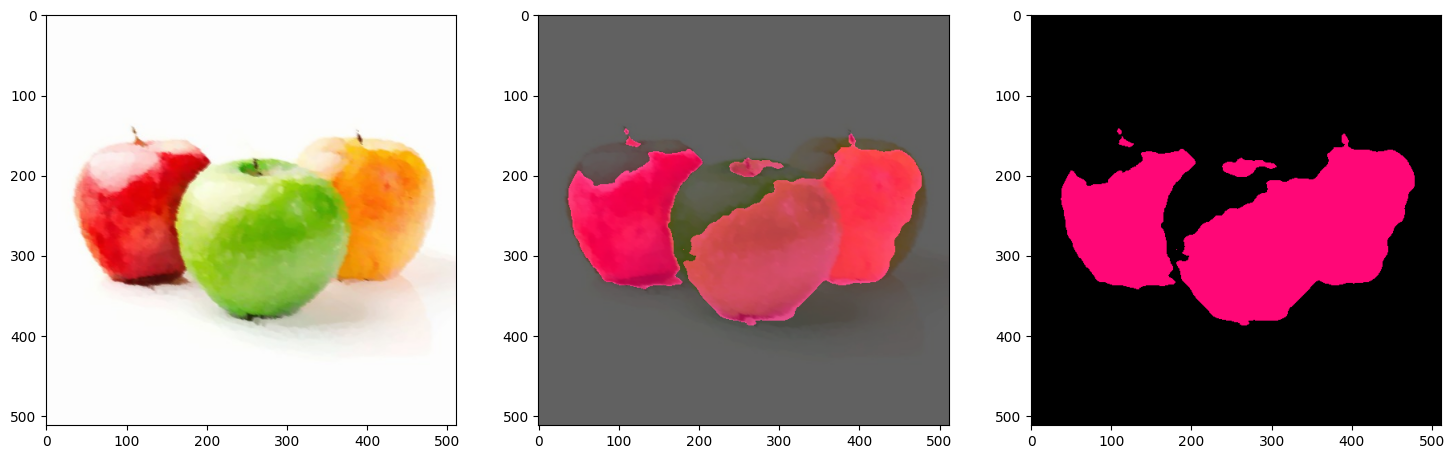

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step


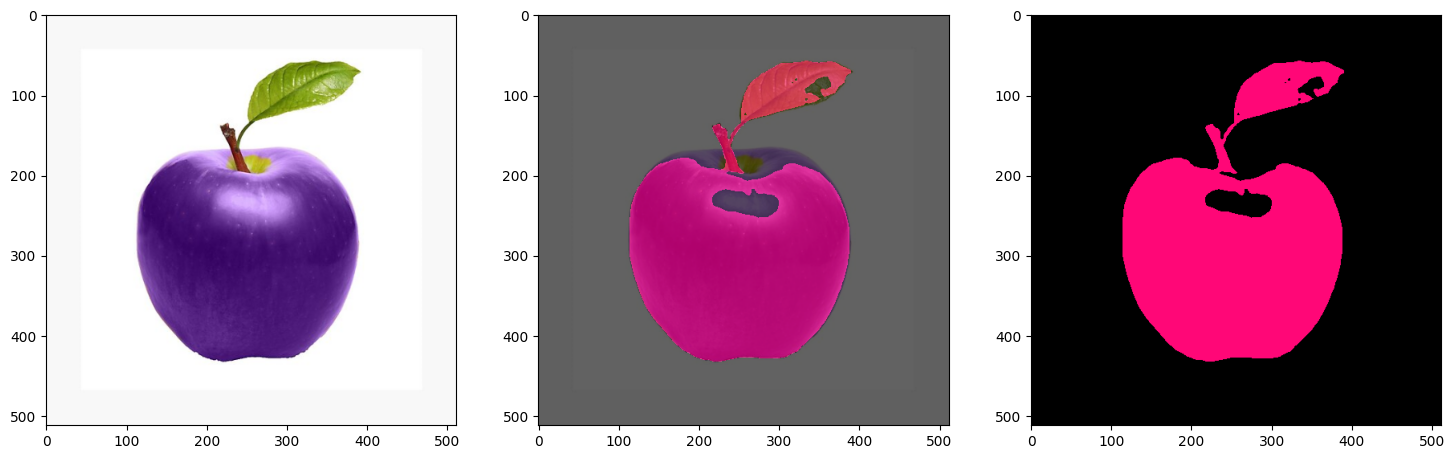

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


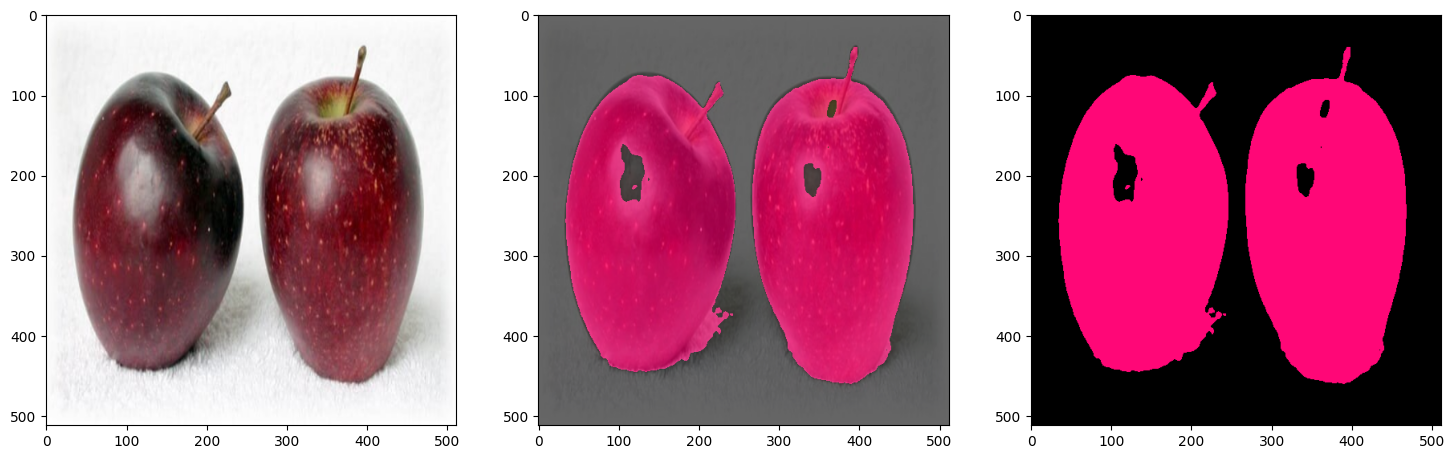

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step


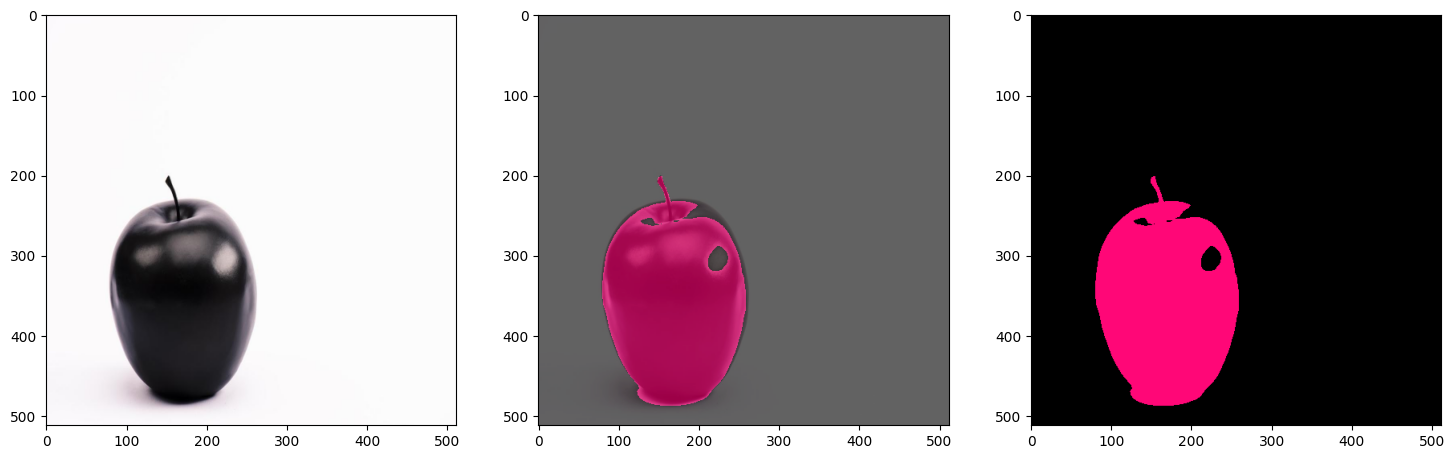

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step


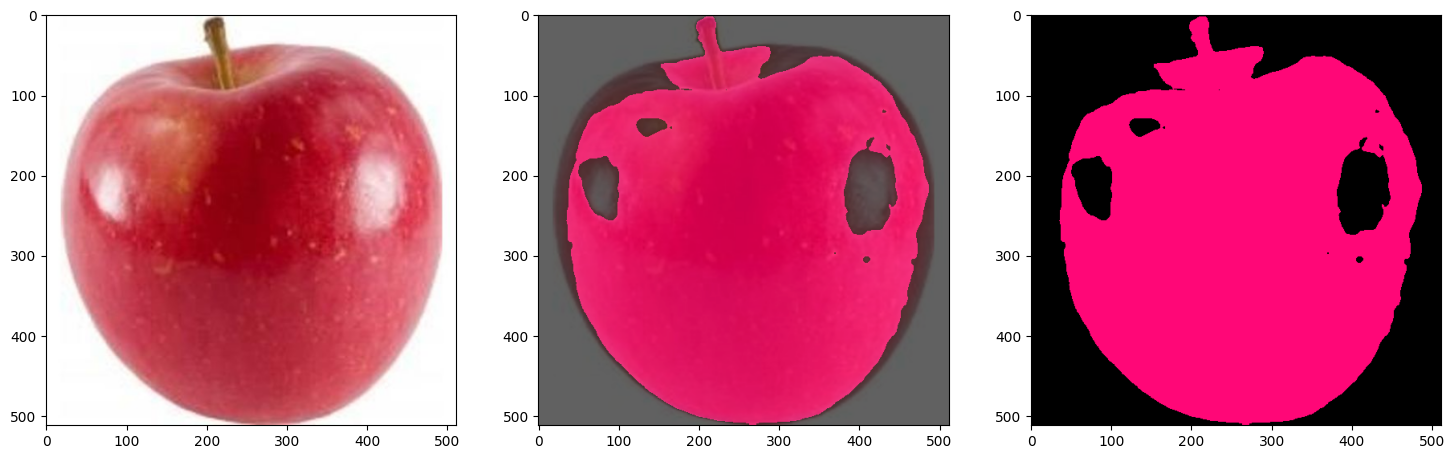

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step


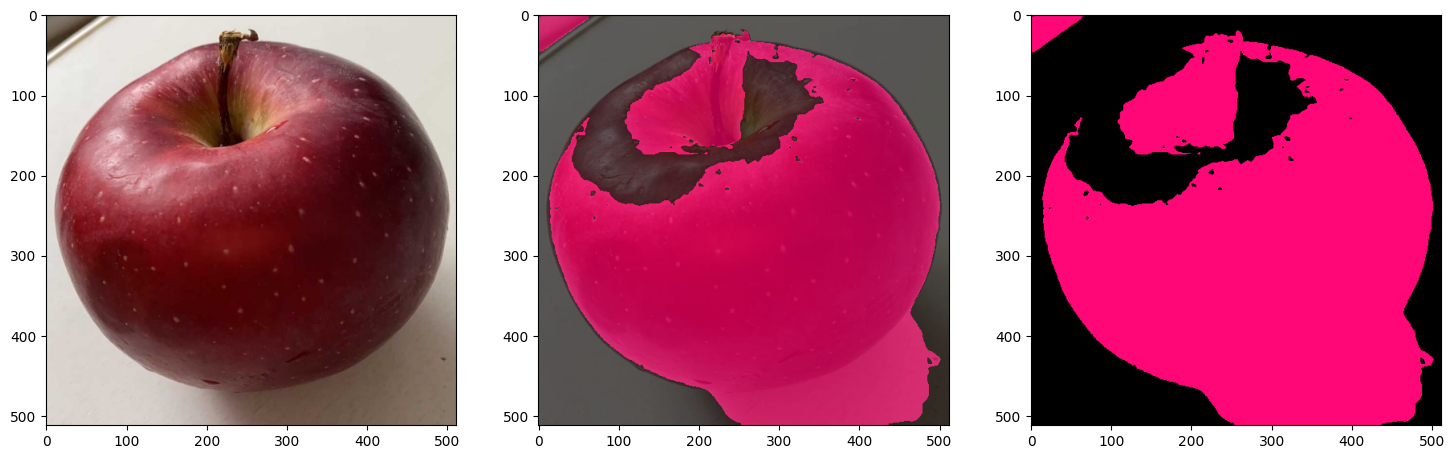

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step


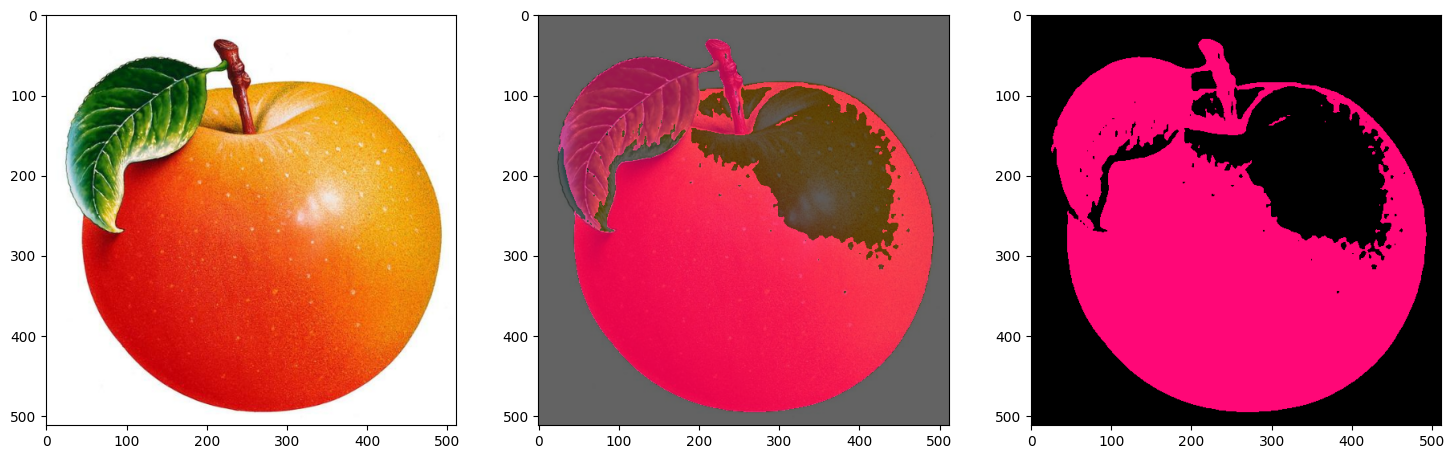

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step


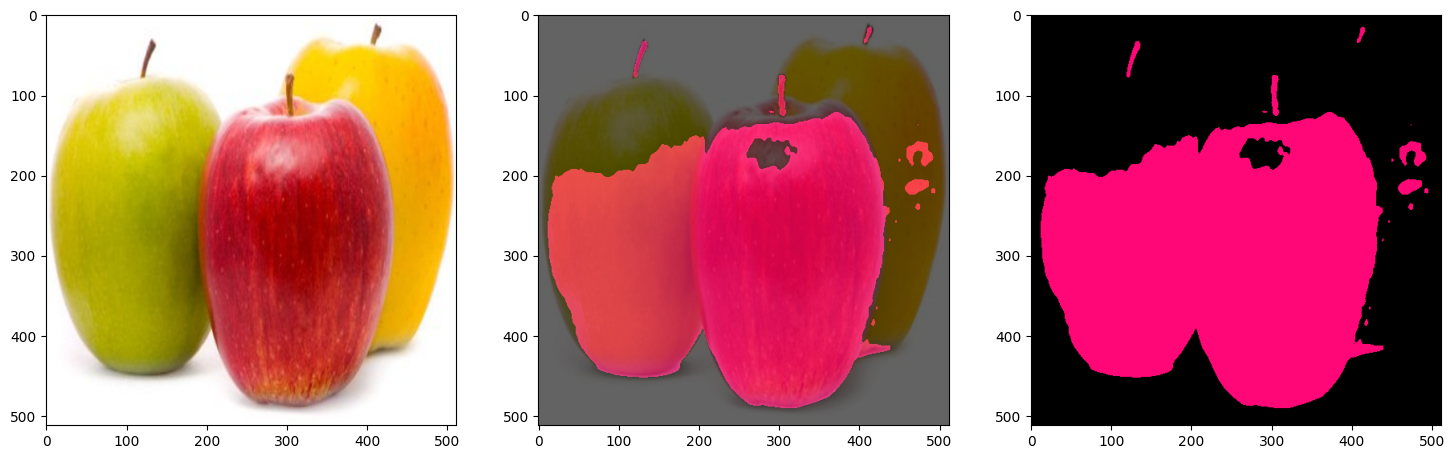

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step


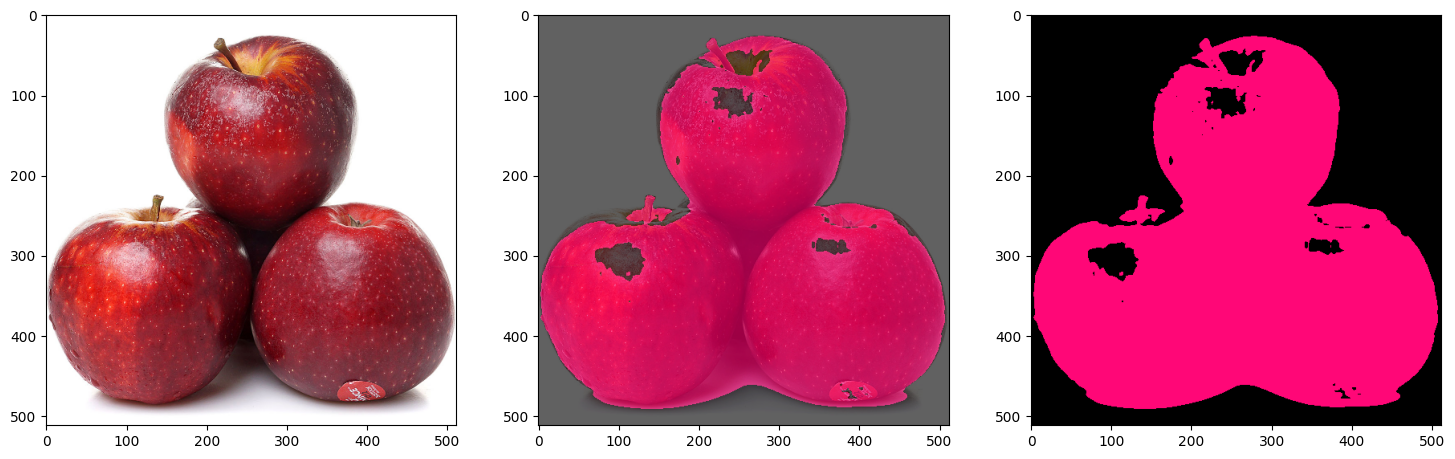

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step


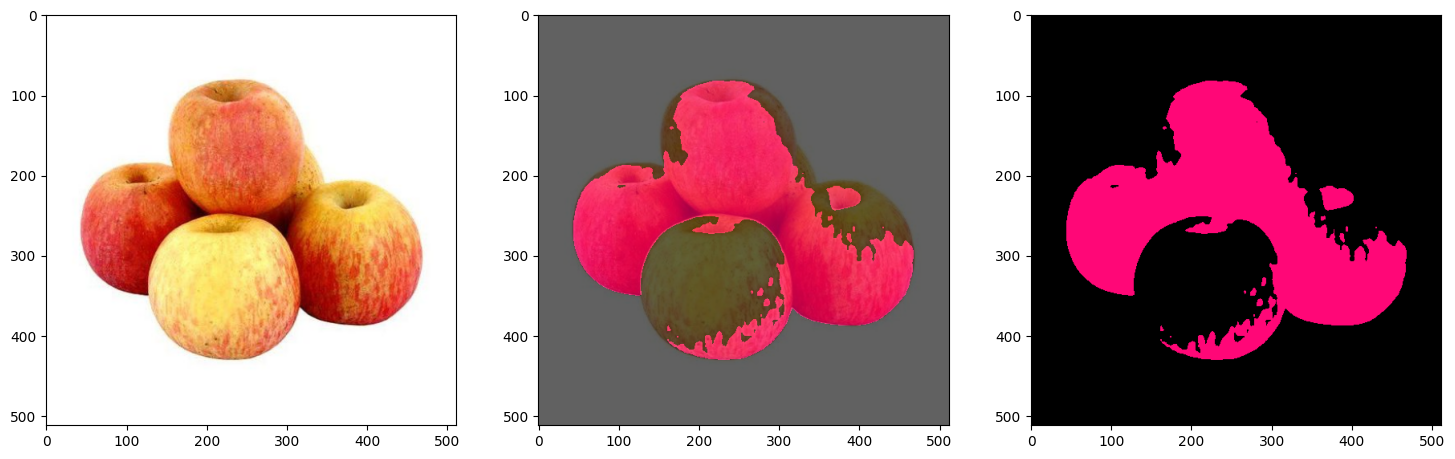

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step


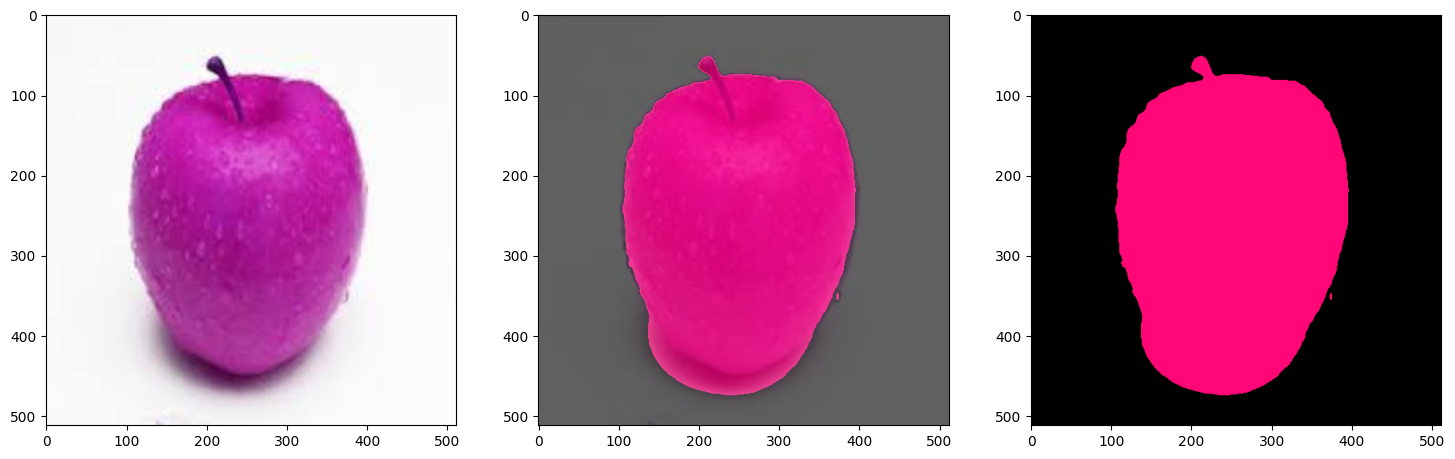

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


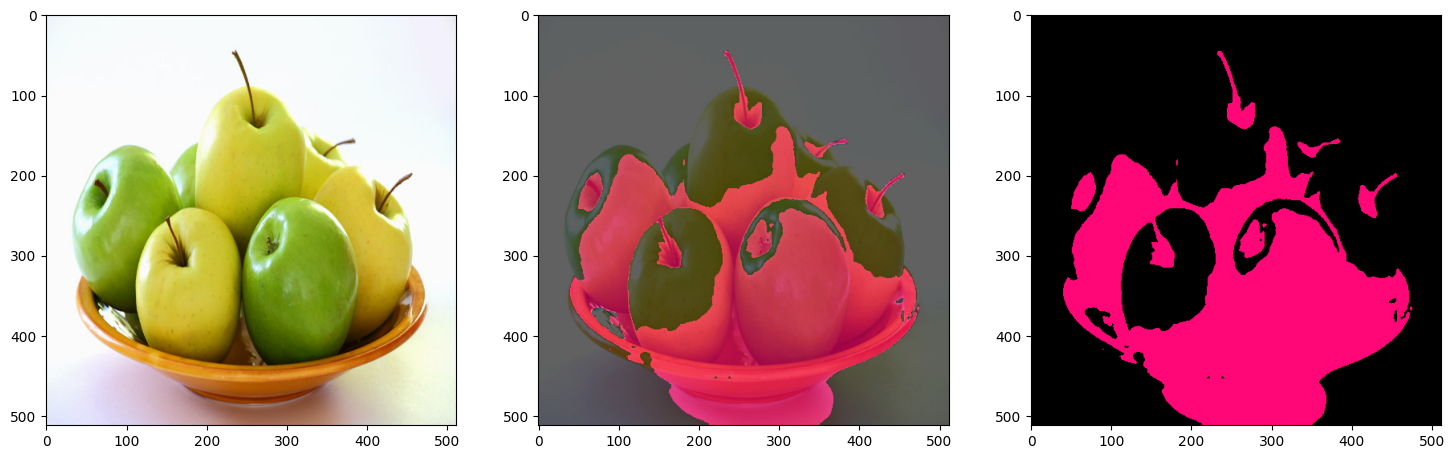

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


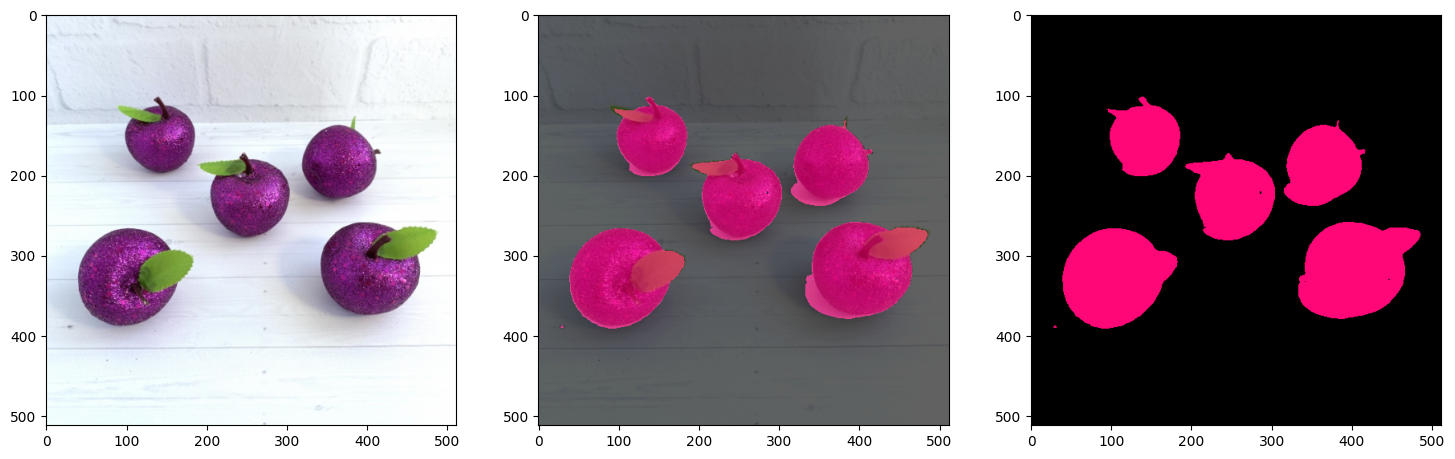

In [27]:
NUM_TEST_IMAGES = 16

test_images = sorted(glob(os.path.join(DATA_DIR, "img_test/*")))[:NUM_TEST_IMAGES]
plot_predictions(test_images, colormap, model=model, mask_pred=True)

# Проверяем метрику IOU для тестовых изображений 
(для оценки используются маски, предсказанные моделью и маски, созданные программным обеспечением)

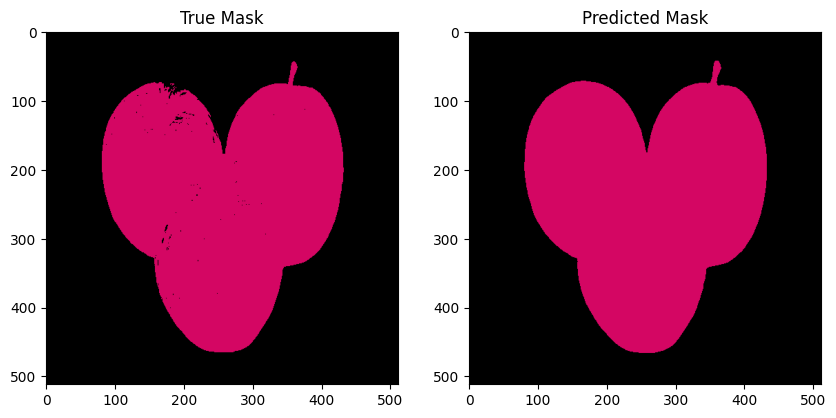

image0 IOU: 0.9809531578196056


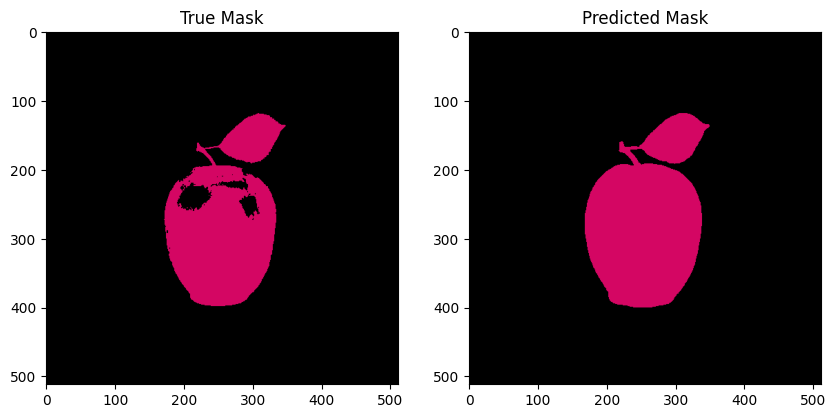

image1 IOU: 0.8484723974994864


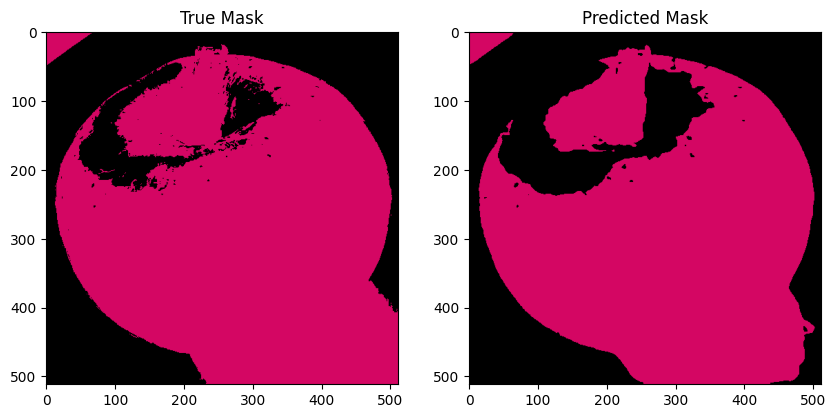

image2 IOU: 0.9163419600369797


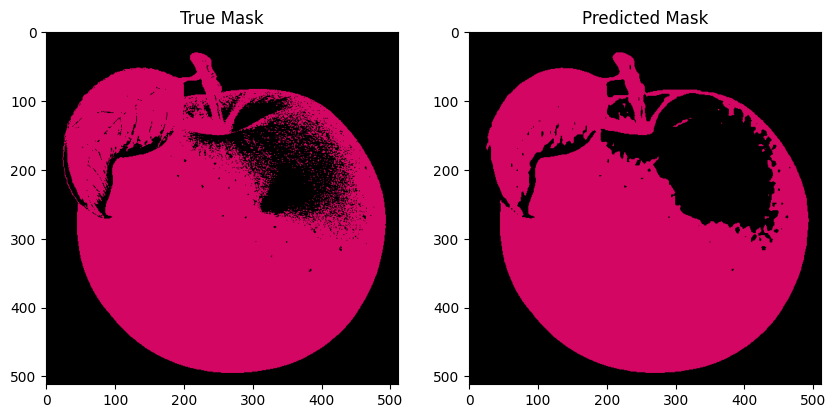

image3 IOU: 0.9026786733645393


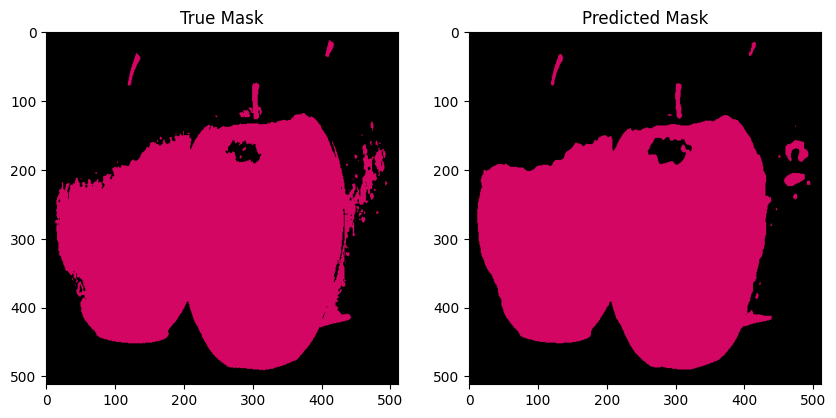

image4 IOU: 0.9342590015227679


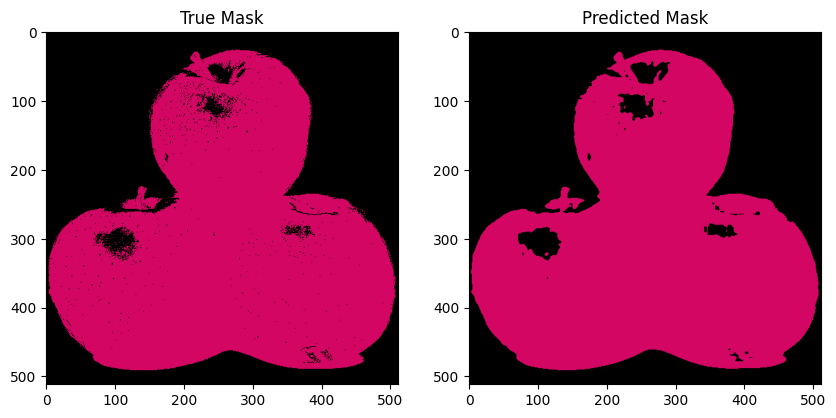

image5 IOU: 0.9689313297174469


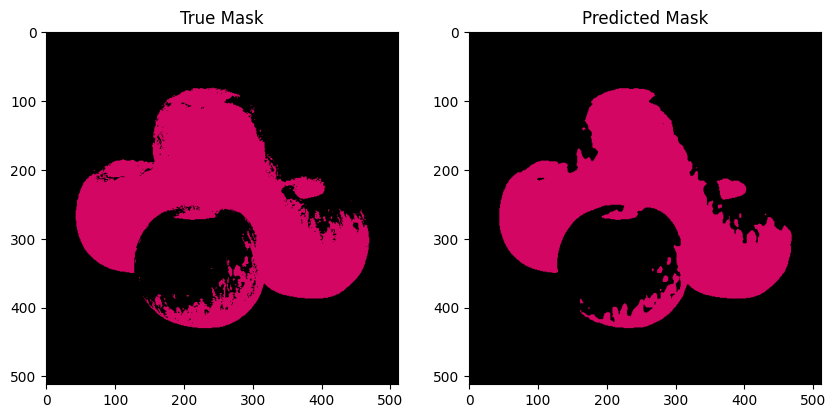

image6 IOU: 0.8952619562961426


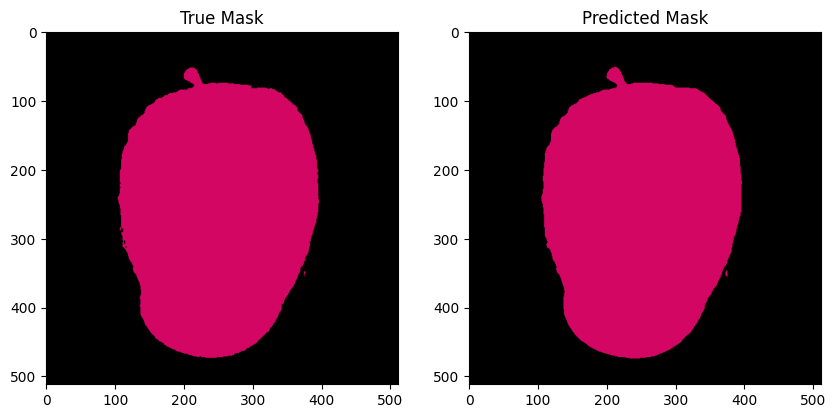

image7 IOU: 0.9946935980828483


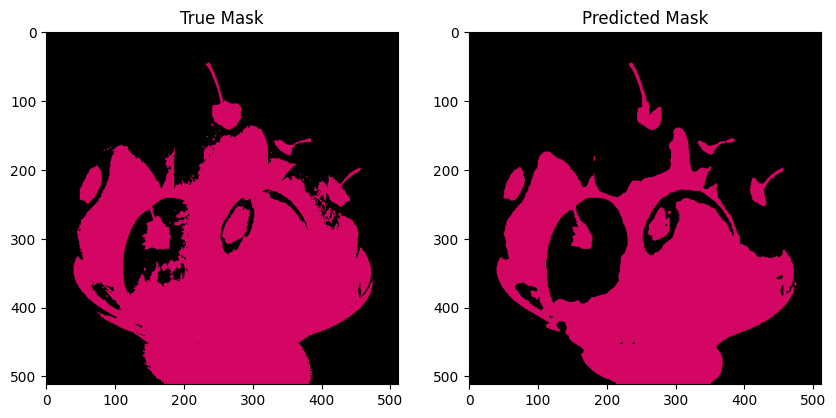

image8 IOU: 0.7764731566557825


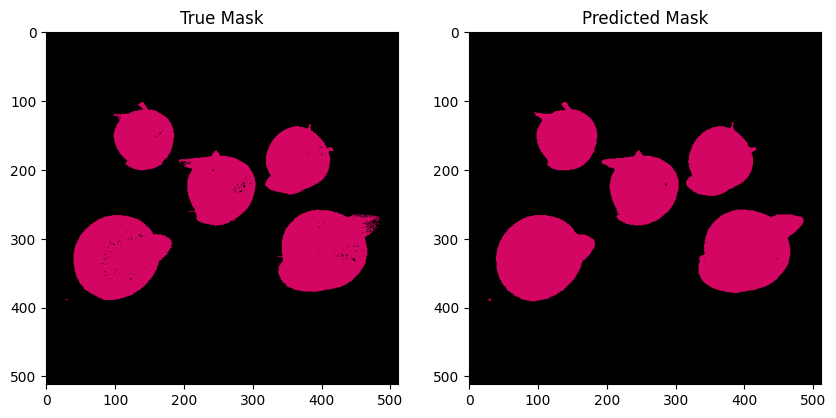

image9 IOU: 0.9630791455990094


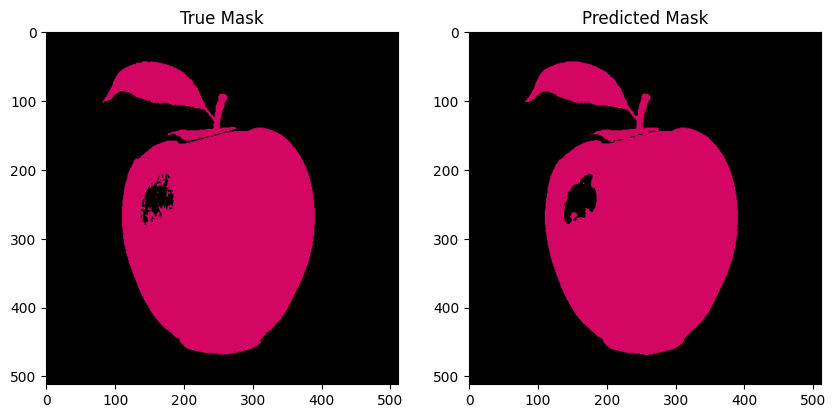

image10 IOU: 0.9872121788772598


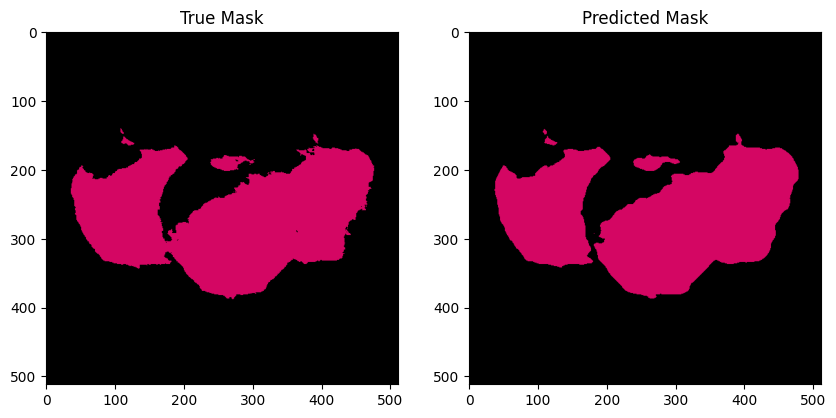

image11 IOU: 0.9598821548821549


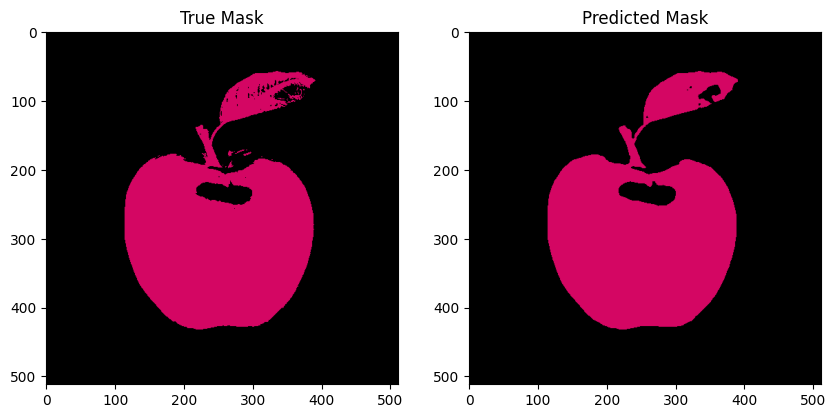

image12 IOU: 0.9757618962751737


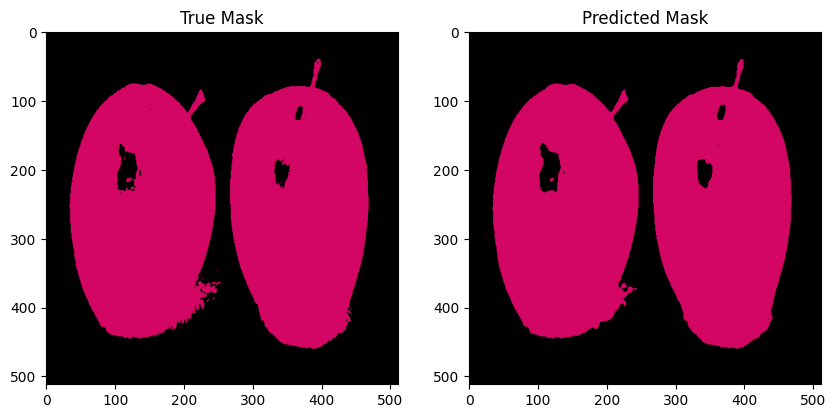

image13 IOU: 0.9878657458925182


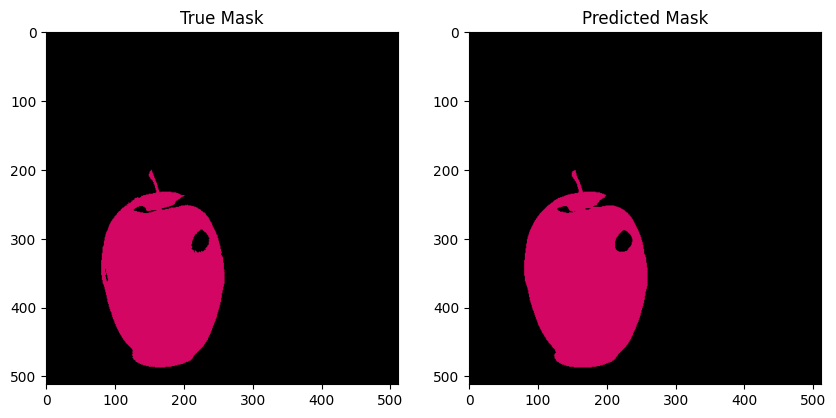

image14 IOU: 0.9889266246182825


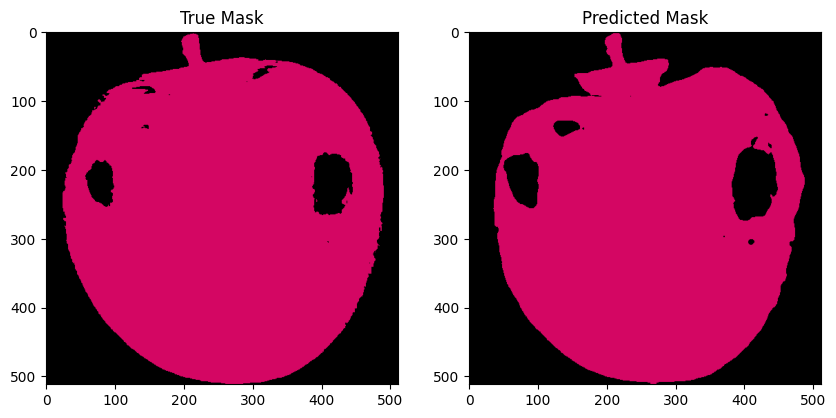

image15 IOU: 0.9206851305122077

MIOU: 0.9375923817282628


In [28]:
IOU_sum = 0
for i in range(NUM_TEST_IMAGES):
    true_mask = cv2.imread(f"C:/Users/iraor/apples_dataset2/mask_true/image{i}.png")
    pred_mask = cv2.imread(f"C:/Users/iraor/apples_dataset2/mask_predict/image{i}.png")
    
    intersection = 0
    union = 0
    sum = 0
    
    for k in range(true_mask.shape[0]):
        for l in range(true_mask.shape[1]):
            if (list(true_mask[k, l]) == [99, 6, 212]) and (list(true_mask[k, l]) == list(pred_mask[k, l])): 
                intersection+=1
            if list(true_mask[k, l]) == [99, 6, 212]:
                sum+=1
            if list(pred_mask[k, l]) == [99, 6, 212]:
                sum+=1
            union = sum - intersection

    IOU = intersection/union

    true_mask = cv2.cvtColor(true_mask, cv2.COLOR_BGR2RGB)
    pred_mask = cv2.cvtColor(pred_mask, cv2.COLOR_BGR2RGB)
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(true_mask)
    axs[0].set_title('True Mask')
    axs[1].imshow(pred_mask)
    axs[1].set_title('Predicted Mask')
    plt.show()
    
    print(f"image{i} IOU: {IOU}")
    IOU_sum += IOU

MIOU = IOU_sum / NUM_TEST_IMAGES
print(f"\nMIOU: {MIOU}")


# test2 алгоритм otsu


In [4]:
# import cv2
# IMAGE_SIZE = 512

# for i in range(17):
#     img = cv2.imread(f"C:/Users/iraor/PycharmProjects/FusionBrainGen/images/apple/original/image{i}.png")
#     img2 = cv2.resize(img, [IMAGE_SIZE, IMAGE_SIZE], cv2.INTER_AREA)
#     cv2.imwrite(f"C:/Users/iraor/PycharmProjects/FusionBrainGen/images/apple/original/image{i}.png", img2)